In [2]:
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt

# Preprocess LHS simulation results

In [3]:
path0='C:/Users/jisma/altamira/kawesqar24'
path='..'

In [18]:
result_files = [file for file in os.listdir(path0+'/results') if 'stat' in file]
Nexp = len(result_files)
print('Number of experiments:', Nexp)

Number of experiments: 1000


In [48]:
df0=pd.read_csv(path0+'/results/'+result_files[0], sep=',', skiprows=range(6)).head(1)
model_parameters=df0.columns[:5].to_list()
print('Model parameters:')
for p in model_parameters: print(p) 
model_varables=df0.columns[5:].to_list()
print('\nModel variables:')
for v in model_varables: print(v)

Model parameters:
mu-logistic-whaling-success
whaling-harm-prob
theta
mutation-prob
n-people

Model variables:
[step]
(mean) average-whale-hunt
(std) average-whale-hunt
(mean) average-help-others
(std) average-help-others
(mean) average-fitness
(std) average-fitness
(mean) average-resources
(std) average-resources
(mean) average-social-capital
(std) average-social-capital
(mean) average-disabled
(std) average-disabled


In [81]:
Nsteps = 1000 # Number of the last steps to be considered in the analysis

In [101]:
# stationary state results
dfr=df0.iloc[:1,:].copy() # pd.DataFrame(columns=df0.columns) # concatenation with empty is deprecated in Pandas
dfr['experiment']=None
for file in result_files:
    df=pd.read_csv(path0+'/results/'+file, sep=',', skiprows=range(6)).tail(Nsteps)
    df['experiment']=int(re.findall(r'\d+', file)[0])
    dfr=pd.concat([dfr,df],axis=0,ignore_index=True)
dfr=dfr.iloc[1:].reset_index(drop=True) # remove the first row
dfr.to_csv(path+'/results/stationary_state.csv',index=False)

# Random Forest parameter importance analysis

In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold, GroupKFold
from sklearn.multioutput import MultiOutputRegressor

In [5]:
dfr=pd.read_csv(path+'/results/stationary_state.csv')
print('Number of rows:',dfr.shape[0])

Number of rows: 1000000


In [111]:
for i in range(len(dfr.columns)): print(i, dfr.columns[i])

0 mu-logistic-whaling-success
1 whaling-harm-prob
2 theta
3 mutation-prob
4 n-people
5 [step]
6 (mean) average-whale-hunt
7 (std) average-whale-hunt
8 (mean) average-help-others
9 (std) average-help-others
10 (mean) average-fitness
11 (std) average-fitness
12 (mean) average-resources
13 (std) average-resources
14 (mean) average-social-capital
15 (std) average-social-capital
16 (mean) average-disabled
17 (std) average-disabled
18 experiment


In [118]:
X = dfr.iloc[:, :4].values  # Model paramter (excecp n-people)
y = dfr.iloc[:, [6,8]].values  # Output variables: '(mean) average-whale-hunt' and '(mean) average-help-others'
groups = dfr.iloc[:, -1].values  # 'Experiment' is used for stratification

In [119]:
# Random Forest model
seed=1234
base_model = RandomForestRegressor(n_estimators=100, random_state=seed)
model = MultiOutputRegressor(base_model)

# Stratified 5-fold cross-validation
gkf = GroupKFold(n_splits=5)
scores = cross_val_score(model, X, y, groups=groups, cv=gkf)
print('Cross-validation scores:', scores)
print('Average cross-validation score:', np.mean(scores))


Cross-validation scores: [0.91264864 0.85818253 0.89479501 0.85609419 0.89893771]
Average cross-validation score: 0.8841316175652603


In [120]:
# Parameter importance by 5-fold cross-validation
parameter_importances = []

for train_index, test_index in gkf.split(X, y, groups=groups):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    base_model = RandomForestRegressor(n_estimators=100, random_state=seed)
    model = MultiOutputRegressor(base_model)
    model.fit(X_train, y_train)
    fold_importances = [est.feature_importances_ for est in model.estimators_]
    parameter_importances.append(fold_importances)


In [142]:
# Parameter importance for (mean) average-whale-hunt
df_whale_hunt=pd.DataFrame([x[0] for x in parameter_importances],columns=model_parameters[:-1])
df_whale_hunt.to_csv(path+'/results/parameter_importance_whale_hunt.csv',index=False)
df_whale_hunt

,mu-logistic-whaling-success,whaling-harm-prob,theta,mutation-prob
0,0.064011,0.390407,0.521142,0.024440
1,0.079614,0.388906,0.502770,0.028709
2,0.079756,0.388047,0.499504,0.032693
3,0.058671,0.381117,0.534257,0.025955
4,0.077274,0.401200,0.489573,0.031953


In [143]:
df_whale_hunt.mean().sort_values(ascending=False)

theta                          0.509449
whaling-harm-prob              0.389935
mu-logistic-whaling-success    0.071865
mutation-prob                  0.028750
dtype: float64

In [144]:
# Parameter importance for (mean) average-help-others
df_help_others=pd.DataFrame([x[1] for x in parameter_importances],columns=model_parameters[:-1])
df_help_others.to_csv(path+'/results/parameter_importance_help_others.csv',index=False)
df_help_others

,mu-logistic-whaling-success,whaling-harm-prob,theta,mutation-prob
0,0.011015,0.214625,0.759512,0.014848
1,0.017912,0.215308,0.749197,0.017583
2,0.009238,0.226948,0.753184,0.010629
3,0.019085,0.209285,0.758468,0.013162
4,0.016163,0.211361,0.756086,0.016390


In [145]:
df_help_others.mean().sort_values(ascending=False)

theta                          0.755290
whaling-harm-prob              0.215505
mu-logistic-whaling-success    0.014683
mutation-prob                  0.014522
dtype: float64

# Exploratory analysis

In [6]:
plt.style.use('ggplot')

In [7]:
# Average time series of the last ticks by experiment
dfr_sum=dfr.groupby('experiment').mean()

In [8]:
# Classification of the experiments into deciles of the risk of 'whaling-harm-prob'
dfr_sum['risk_decile'] = pd.qcut(dfr_sum['whaling-harm-prob'], q=10, labels=False)
dfr_sum['risk_quartile'] = pd.qcut(dfr_sum['whaling-harm-prob'], q=4, labels=False)

In [9]:
# Classification of the experiments into deciles of 'theta'
dfr_sum['theta_decile'] = pd.qcut(dfr_sum['theta'], q=10, labels=False)

In [10]:
dfr_sum.columns

Index(['mu-logistic-whaling-success', 'whaling-harm-prob', 'theta',
       'mutation-prob', 'n-people', '[step]', '(mean) average-whale-hunt',
       '(std) average-whale-hunt', '(mean) average-help-others',
       '(std) average-help-others', '(mean) average-fitness',
       '(std) average-fitness', '(mean) average-resources',
       '(std) average-resources', '(mean) average-social-capital',
       '(std) average-social-capital', '(mean) average-disabled',
       '(std) average-disabled', 'risk_decile', 'risk_quartile',
       'theta_decile'],
      dtype='object')

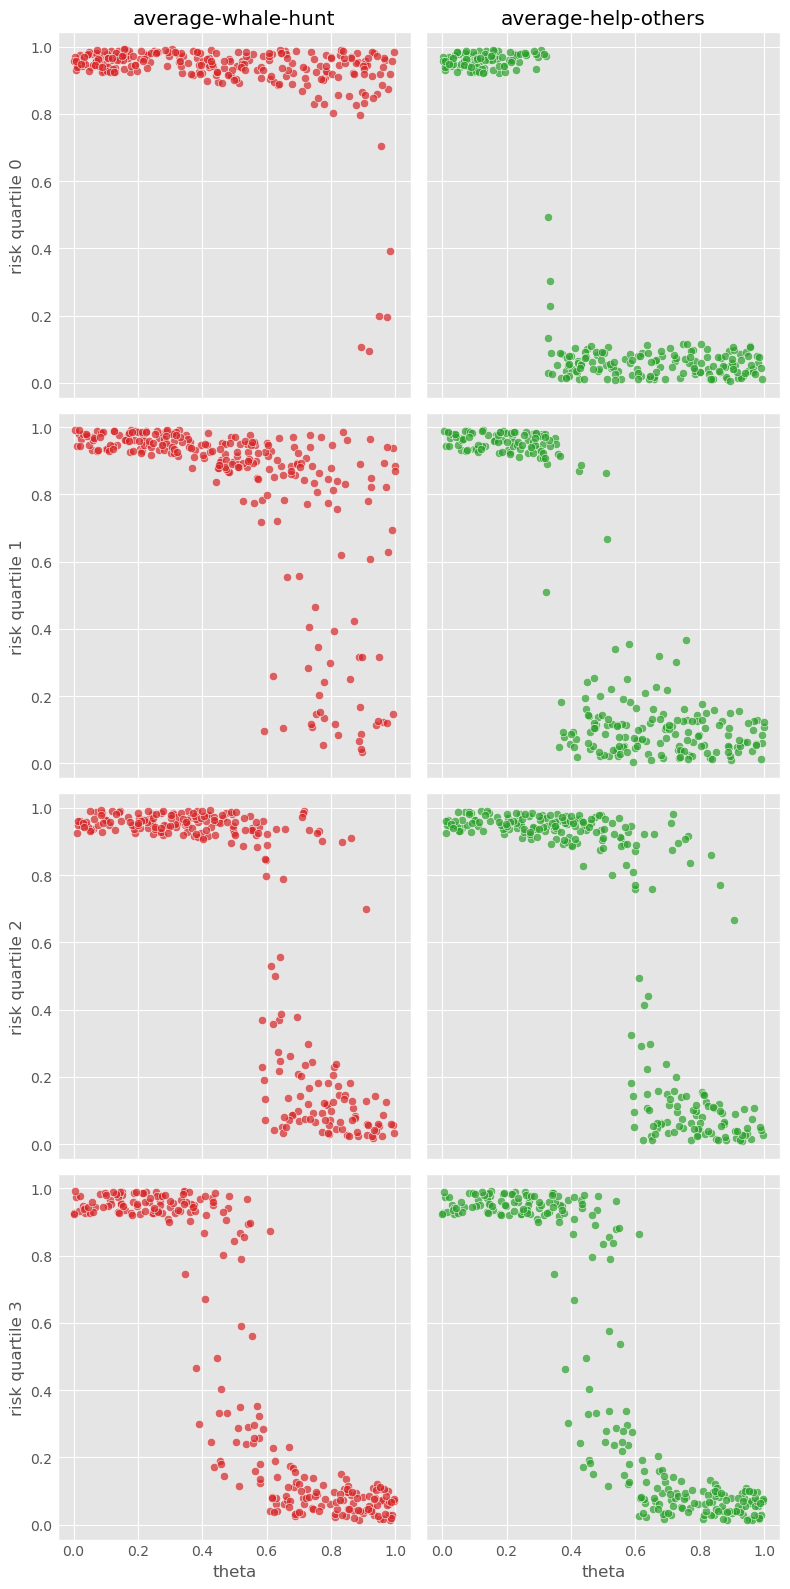

In [92]:
# average-whale-hunt vs. average-help-others by deciles of 'whaling-harm-prob'
fig, axs = plt.subplots(4, 2, figsize=(8, 16), sharex=True, sharey=True)
averages=[(0,'(mean) average-whale-hunt'),(1,'(mean) average-help-others')]
colors=['tab:red', 'tab:green']
for i,variable in averages:
    for j in range(4): # quantiles of 'whaling-harm-prob'
        axs[j, i].scatter(x=dfr_sum[dfr_sum['risk_quartile']==j]['theta'], 
                      y=dfr_sum[dfr_sum['risk_quartile']==j][variable], color=colors[i],edgecolors='white', alpha=0.7)
axs[0, 0].set_title('average-whale-hunt')
axs[0, 1].set_title('average-help-others')
axs[3, 0].set_xlabel('theta')
axs[3, 1].set_xlabel('theta')
for j in range(4):
    axs[j, 0].set_ylabel('risk quartile '+str(j))
fig.tight_layout()
plt.show()

In [11]:
# Classification of the experiments into deciles of '(mean) average-whale-hunt'
dfr_sum['whale_hunt_decile'] = pd.qcut(dfr_sum['(mean) average-whale-hunt'], q=10, labels=False)
# Classification of the experiments into deciles of '(mean) average-help-others'
dfr_sum['help_others_decile'] = pd.qcut(dfr_sum['(mean) average-help-others'], q=10, labels=False)

In [12]:
parameters=['theta','whaling-harm-prob','mu-logistic-whaling-success']

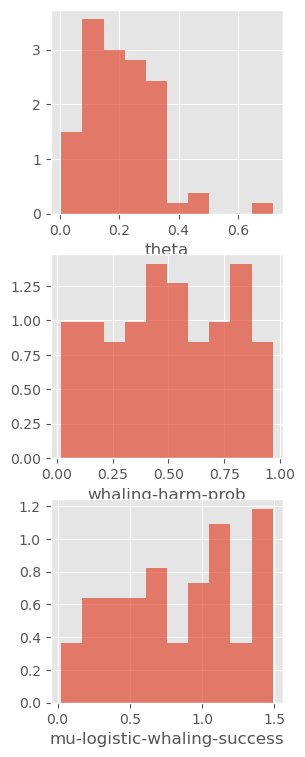

In [17]:
# All cooperation
Dw=9
Dh=9
fig, axs = plt.subplots(len(parameters), 1, figsize=(3, 9))
df_coop=dfr_sum[(dfr_sum['whale_hunt_decile']>=Dw) & (dfr_sum['help_others_decile']>=Dh)]
for i in range(len(parameters)):
    axs[i].hist(df_coop[parameters[i]],density=True, alpha=0.7, label=parameters[i])
    axs[i].set_xlabel(parameters[i]) 
plt.show()

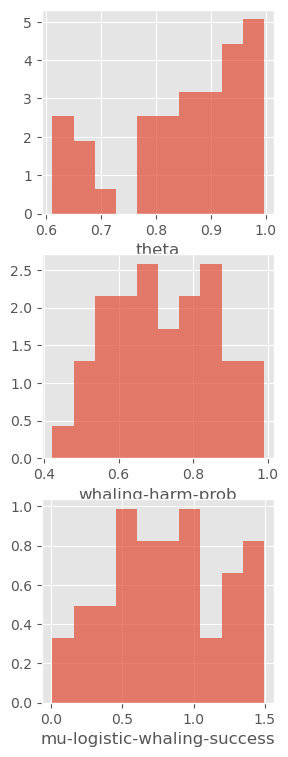

In [20]:
# All defection
Dw=0
Dh=0
fig, axs = plt.subplots(len(parameters), 1, figsize=(3, 9))
df_coop=dfr_sum[(dfr_sum['whale_hunt_decile']<=Dw) & (dfr_sum['help_others_decile']<=Dh)]
for i in range(len(parameters)):
    axs[i].hist(df_coop[parameters[i]],density=True, alpha=0.7, label=parameters[i])
    axs[i].set_xlabel(parameters[i]) 
plt.show()

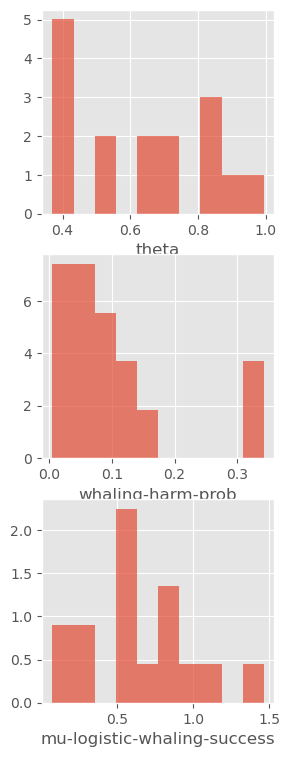

In [13]:
# Only cooperation in whale hunt
Dw=9
Dh=0
fig, axs = plt.subplots(len(parameters), 1, figsize=(3, 9))
df_coop=dfr_sum[(dfr_sum['whale_hunt_decile']>=Dw) & (dfr_sum['help_others_decile']<=Dh)]
for i in range(len(parameters)):
    axs[i].hist(df_coop[parameters[i]],density=True, alpha=0.7, label=parameters[i])
    axs[i].set_xlabel(parameters[i]) 
plt.show()

In [125]:
# Only cooperation in help others: none

In [14]:
dfr_sum['state']=None
dfr_sum.loc[(dfr_sum['whale_hunt_decile']>=9) & (dfr_sum['help_others_decile']>=9),'state']='AC' # All cooperation
dfr_sum.loc[(dfr_sum['whale_hunt_decile']<=0) & (dfr_sum['help_others_decile']<=0),'state']='AD' # All defection
dfr_sum.loc[(dfr_sum['whale_hunt_decile']>=9) & (dfr_sum['help_others_decile']<=0),'state']='OCWH' # Only cooperation in whale hunt
dfr_sum[['state']].groupby('state').size()/dfr_sum[['state']].groupby('state').size().sum()

state
AC      0.568182
AD      0.310606
OCWH    0.121212
dtype: float64

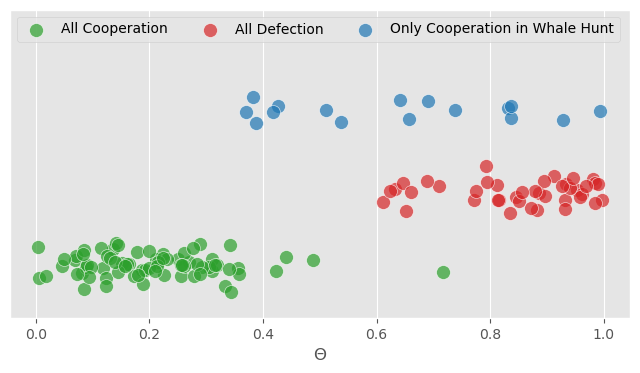

In [32]:
# Distribution of 'theta' by state
states=[('AC','All Cooperation'),('AD','All Defection'),('OCWH','Only Cooperation in Whale Hunt')]
colors = ['tab:green', 'tab:red', 'tab:blue']
fig, ax = plt.subplots(figsize=(8, 4))

for i in range(len(states)):
    ax.scatter(dfr_sum.loc[dfr_sum['state']==states[i][0],'theta'], 
               np.random.normal(loc=0.15*i,scale=0.02,size=dfr_sum.loc[dfr_sum['state']==states[i][0]].shape[0]), 
               color=colors[i], edgecolors='white', s=100, alpha=0.7, label=states[i][1])
ax.set(ylim=(-0.1, 0.5))
ax.yaxis.set_visible(False)
ax.yaxis.grid(False) 
ax.set_xlabel(r'$\Theta$')
ax.legend(loc='upper left', ncols=3)

plt.show()

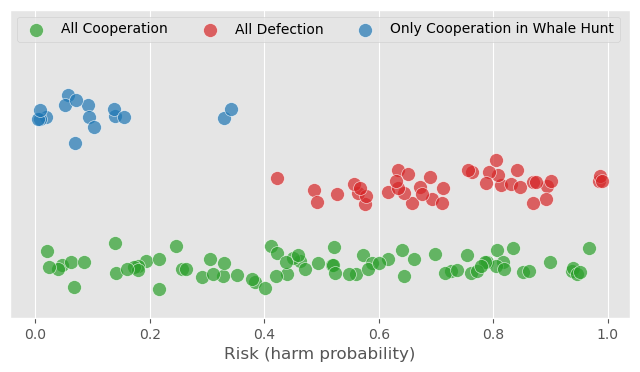

In [34]:
# Distribution of 'whaling-harm-prob' by state
states=[('AC','All Cooperation'),('AD','All Defection'),('OCWH','Only Cooperation in Whale Hunt')]
colors = ['tab:green', 'tab:red', 'tab:blue']
fig, ax = plt.subplots(figsize=(8, 4))

for i in range(len(states)):
    ax.scatter(dfr_sum.loc[dfr_sum['state']==states[i][0],'whaling-harm-prob'], 
               np.random.normal(loc=0.15*i,scale=0.02,size=dfr_sum.loc[dfr_sum['state']==states[i][0]].shape[0]), 
               color=colors[i], edgecolors='white', s=100, alpha=0.7, label=states[i][1])
ax.set(ylim=(-0.1, 0.5))
ax.yaxis.set_visible(False)
ax.yaxis.grid(False) 
ax.set_xlabel('Risk (harm probability)')
ax.legend(loc='upper left', ncols=3)

plt.show()

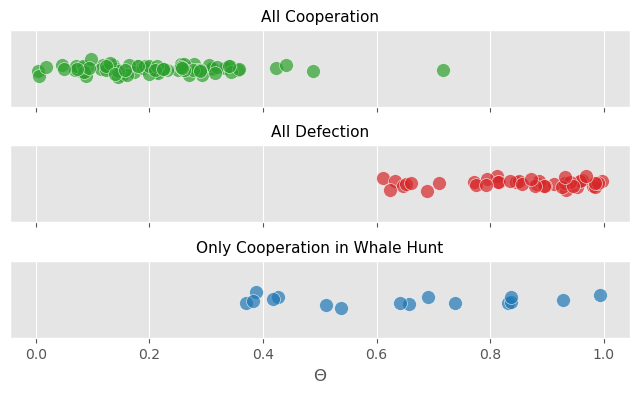

In [35]:
# Distribution of 'theta' by state
states=[('AC','All Cooperation'),('AD','All Defection'),('OCWH','Only Cooperation in Whale Hunt')]
colors = ['tab:green', 'tab:red', 'tab:blue']
fig, axs = plt.subplots(len(states), 1, figsize=(8, 4),sharex=True, sharey=True)
for i in range(len(states)):
    axs[i].scatter(dfr_sum.loc[dfr_sum['state']==states[i][0],'theta'], 
           np.random.normal(loc=0,scale=0.025,size=dfr_sum.loc[dfr_sum['state']==states[i][0]].shape[0]), 
           color=colors[i],edgecolors='white',s=100, alpha=0.7, label=states[i][0])
    axs[i].set_title(states[i][1], fontsize=11)
    axs[i].set(ylim=(-0.25, 0.25))
    axs[i].yaxis.set_visible(False)
    axs[i].yaxis.grid(False) 
axs[len(states)-1].set_xlabel(r'$\Theta$')
plt.subplots_adjust(hspace=0.5)
plt.show()

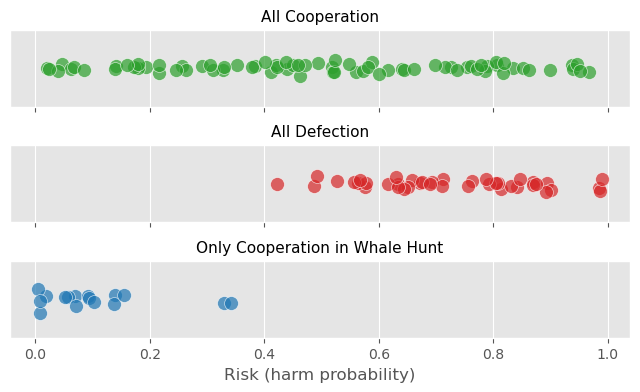

In [36]:
# Distribution of 'whaling-harm-prob' by state
states=[('AC','All Cooperation'),('AD','All Defection'),('OCWH','Only Cooperation in Whale Hunt')]
colors = ['tab:green', 'tab:red', 'tab:blue']
fig, axs = plt.subplots(len(states), 1, figsize=(8, 4),sharex=True, sharey=True)
for i in range(len(states)):
    axs[i].scatter(dfr_sum.loc[dfr_sum['state']==states[i][0],'whaling-harm-prob'], 
           np.random.normal(loc=0,scale=0.025,size=dfr_sum.loc[dfr_sum['state']==states[i][0]].shape[0]), 
           color=colors[i],edgecolors='white',s=100, alpha=0.7, label=states[i][0])
    axs[i].set_title(states[i][1], fontsize=11)
    axs[i].set(ylim=(-0.25, 0.25))
    axs[i].yaxis.set_visible(False)
    axs[i].yaxis.grid(False) 
axs[len(states)-1].set_xlabel('Risk (harm probability)')
plt.subplots_adjust(hspace=0.5)
plt.show()